# Intro to Transfer Learning with ImageNet-trained Models
----

(provided by Cal Kaggle Team for SUSA Fall 2017 Kaggle Workshop)

In this kernel, we will cover the basics of loading in a pretrained model using Keras and building another classifier on top of it.

[Thanks to Beluga for their kernel](https://www.kaggle.com/gaborfodor/use-pretrained-keras-models-lb-0-3)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from tqdm import tqdm
from keras.models import Model, Sequential
from keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


## Setup

Here we specify some parameters about our data that we will need to use the pretrained models

In [2]:
INPUT_SIZE = 224
# For efficiency, we will only predict on the 32 most frequent dog breeds
NUM_CLASSES = 32

# Seeding is for reproducibility purposes 
# Like if we were to split the dataset into train/validation/test
SEED = 1987
data_dir = "../train/"
labels = pd.read_csv('labels.csv')
sample_submission = pd.read_csv('sample_submission.csv')
print(len(listdir('train')), len(labels))
print(len(listdir('test')), len(sample_submission))

10222 10222
10358 10357


## Getting the 32 Most Frequent Dog Breeds

In [3]:
# This is some Pandas magic
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

# Here we seed the random generator which splits our dataset
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

## Checking Number of Dog Breeds Captured

Yup, that's 32

In [1]:
labels['breed'].unique()

NameError: name 'labels' is not defined

## Here is a function specified by Beluga

It's really helpful because it loads an image into memory from some really common parameters, like the filename, testdir, and the size we want our image to be.

In [4]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

## ResNet50

This is a really great model that was introduced by Microsoft's Research team, and in Keras, it only takes one line of code to run.

In [5]:
model = ResNet50(weights='imagenet')

## Practicing Prediction

Keras is fantastic - predicting with the ResNet50 model is one line.
```python
model.predict(matrix_img)
```

In [6]:
img = '7e83c129d2696dad7c9917aa5f31d44a'
out = read_img(img, 'test/', (224, 224))
p_hat = model.predict(np.reshape(out, (1, 224, 224, 3)))

In [7]:
decode_predictions(p_hat)

[[('n02105505', 'komondor', 0.53581125),
  ('n02098105', 'soft-coated_wheaten_terrier', 0.072139345),
  ('n02085936', 'Maltese_dog', 0.04261075),
  ('n02088094', 'Afghan_hound', 0.039620776),
  ('n02113799', 'standard_poodle', 0.032565016)]]

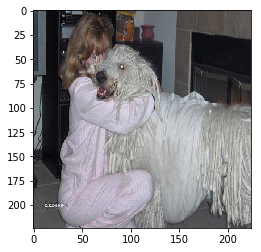

In [8]:
plt.imshow(out / 255)

# We Loaded In an Orange

Just to make sure that ResNet50 has it's weights properly loaded. Since oranges were included in the original ImageNet Task, this should work!

In [9]:
img  = read_img('orange','test',(224, 224))
iimg = np.reshape(img, (1, 224, 224, 3))
o_hat = model.predict(iimg)

In [10]:
decode_predictions(o_hat)

[[('n07747607', 'orange', 0.15713349),
  ('n03637318', 'lampshade', 0.14482981),
  ('n07749582', 'lemon', 0.11067041),
  ('n06359193', 'web_site', 0.071804829),
  ('n03814906', 'necklace', 0.063853212)]]

## It Worked! It's truly an Orange!

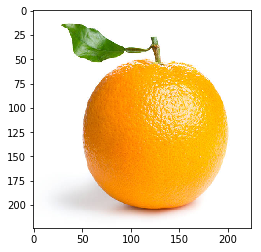

In [11]:
plt.imshow(img/255)

## Transfer Learning

To begin we will need to do two things

1. Use ResNet50 to generate specialized features

2. Train another classifier for dog breeds on those features

---


#### First, Taking a Look At ResNet50

Usually, we want to just take off the last fully connected or "Dense" layers of any pretrained model and retrain a classifier on those, so that's what we'll do. This is mostly just a demonstration of how to access important model architecture info in keras.

In [12]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 112, 112, 64)  9472        input_1[0][0]                    
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 112, 112, 64)  256         conv1[0][0]                      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           bn_conv1[0][0]                   
___________________________________________________________________________________________

#### 0. Loading the Data

In [13]:
# Preprocessing photos for ResNet using VGG preprocessing because they are similar processes
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

3316it [00:15, 211.62it/s]

Train Images shape: (3316, 224, 224, 3) size: 499,150,848


#### 1. Using ResNet50 to generate features from the data

In [3]:
# Getting the feature vectors from ResNet50 include_top=False over VGG-preprocessed output
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

# Load in ResNet50 without the Dense layers
resminustop = ResNet50(weights='imagenet', include_top=False)

# Predicting on the data with this decapitated ResNet50
train_res_bf = resminustop.predict(Xtr, batch_size=32, verbose=1)
valid_res_bf = resminustop.predict(Xv, batch_size=32, verbose=1)
print('ResNet50 train bottleneck features shape: {} size: {:,}'.format(train_res_bf.shape, train_res_bf.size))
print('ResNet50 valid bottleneck features shape: {} size: {:,}'.format(valid_res_bf.shape, valid_res_bf.size))
train_res_bf = np.reshape(train_res_bf, (-1, train_res_bf.shape[-1]))
valid_res_bf = np.reshape(valid_res_bf, (-1, valid_bf.shape[-1]))
print('ResNet50 train bottleneck features shape: {} size: {:,}'.format(train_res_bf.shape, train_res_bf.size))
print('ResNet50 valid bottleneck features shape: {} size: {:,}'.format(valid_res_bf.shape, valid_res_bf.size))

NameError: name 'x_train' is not defined

#### 1b. I messed up so I'm just reshaping again here

In [19]:
train_res_bf = np.reshape(train_res_bf, (-1, train_res_bf.shape[-1]))
valid_res_bf = np.reshape(valid_res_bf, (-1, valid_res_bf.shape[-1]))
print('ResNet50 train bottleneck features shape: {} size: {:,}'.format(train_res_bf.shape, train_res_bf.size))
print('ResNet50 valid bottleneck features shape: {} size: {:,}'.format(valid_res_bf.shape, valid_res_bf.size))

ResNet50 train bottleneck features shape: (2623, 2048) size: 5,371,904
ResNet50 valid bottleneck features shape: (693, 2048) size: 1,419,264


#### 2. Using Logistic Regression on top of ResNet50

In [24]:
# Logistic Regression on top of output of ResNet50-fully connected layers
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_res_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_res_bf)
valid_preds = logreg.predict(valid_res_bf)
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation VGG LogLoss 0.4023775557555569
Validation VGG Accuracy 0.8816738816738817


#### 2b. (Extra) Training a Fully Connected Network ontop of ResNet50

In [4]:
# Reshaping for our Fully Connected Model to work
train_res_bf = np.reshape(train_res_bf, (-1, train_res_bf.shape[-1], 1))
valid_res_bf = np.reshape(valid_res_bf, (-1, valid_res_bf.shape[-1], 1))
print('ResNet50 train bottleneck features shape: {} size: {:,}'.format(train_res_bf.shape, train_res_bf.size))
print('ResNet50 valid bottleneck features shape: {} size: {:,}'.format(valid_res_bf.shape, valid_res_bf.size))

NameError: name 'np' is not defined

In [39]:
dense_model = Sequential()
dense_model.add(Flatten(input_shape=(2048,1)))
dense_model.add(Dense(4096,activation="elu"))
dense_model.add(Dense(1028, activation='elu'))
dense_model.add(Dense(32, activation='softmax'))
dense_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
dense_model.fit(train_res_bf, ytr)

Epoch 1/10
2623/2623 [==============================] - 1s - loss: 15.3775 - acc: 0.0370     
Epoch 2/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
Epoch 3/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
Epoch 4/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
Epoch 5/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
Epoch 6/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
Epoch 7/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
Epoch 8/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
Epoch 9/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
Epoch 10/10
2623/2623 [==============================] - 1s - loss: 15.5159 - acc: 0.0374     
